Trying to fit a single sigma to all the gaussian data

In [1]:
import numpy as np
import matplotlib


from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
from matplotlib import cm
import scipy.stats as st
import scipy.special as spec

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

np.random.seed(0)

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

Try going over EMCEE example outlined in website

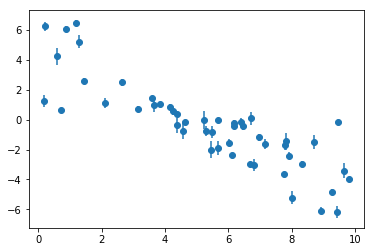

In [2]:
plt.errorbar(x, y, yerr=yerr, fmt= "o")
plt.show()

In [3]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print b_ls, m_ls

3.89442288569 -0.777530675884


In [13]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [14]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print b_ml, m_ml

4.14088775891 -0.894762505549


In [15]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf


In [16]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [17]:
ndim, nwalkers = 3, 100
#print result["x"]


In [18]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500)

(array([[ -6.83964077e-01,   3.06151316e+00,   4.39684490e-03],
        [ -8.79519174e-01,   4.15767644e+00,  -3.22542705e-01],
        [ -8.11732863e-01,   3.76792061e+00,  -3.52767016e-01],
        [ -8.31587188e-01,   3.88567807e+00,  -5.62162441e-01],
        [ -8.63171122e-01,   4.01346074e+00,  -4.33895796e-01],
        [ -9.14926265e-01,   4.27608433e+00,  -4.76346562e-01],
        [ -7.84266691e-01,   3.75120403e+00,  -3.89106130e-01],
        [ -1.04014380e+00,   4.84013329e+00,  -6.80181554e-01],
        [ -7.87197701e-01,   3.77136102e+00,  -5.25160630e-01],
        [ -8.56812730e-01,   4.10326184e+00,  -6.03192103e-01],
        [ -9.17103478e-01,   4.22951617e+00,  -2.83440769e-01],
        [ -8.99029053e-01,   4.09170150e+00,  -6.35392679e-01],
        [ -9.58925965e-01,   4.42889596e+00,  -5.97815587e-01],
        [ -7.98025919e-01,   3.68719686e+00,  -3.04338484e-01],
        [ -8.99506042e-01,   4.28039674e+00,  -4.25321826e-01],
        [ -8.50057054e-01,   3.97654660e

In [11]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [12]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

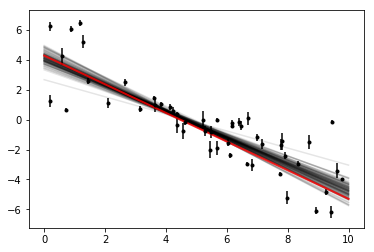

In [14]:
plt.figure()
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.show()

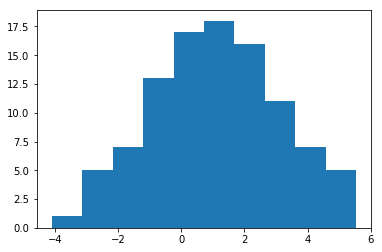

In [21]:
#can assume that the p(mu, sigma), and p(D) is a constant?
#P(D| mu and sigma) --> create a 2 dim contour plot with probabilities
#draw 100 points from a gaussain, and use the maximum likelihood estimator to estimate its parameters
sample_size = 100
np.random.seed(0)
samp_100 = np.random.normal(1,2,sample_size)
#samp_100 = samp_100.sort()
plt.figure()
plt.hist(samp_100)
plt.show()

In [31]:
#calculating the most likely value for mu
mu_mle = 1./sample_size *(samp_100.sum())
print "Mu MLE", mu_mle
#calculating the varience
diff = 0
for val in samp_100:
    diff  += (val - mu_mle)**2

varience = 1./sample_size * diff
print ("Varience: %f and Standard Deviation: %f" % (varience, varience**0.5))

Mu MLE 1.11961603107
Varience: 4.063306 and Standard Deviation: 2.015764


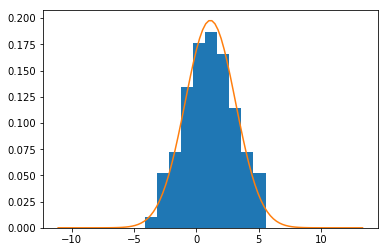

In [42]:
plt.figure()
plt.hist(samp_100, normed=1)

x = np.linspace(mu_mle-3*varience,mu_mle+3*varience, 100)
plt.plot(x, mlab.normpdf(x, mu_mle, varience**0.5))
plt.show()

Work with the delta times for the shadow systems

In [5]:
df = pd.read_csv("../csvs/deltatimes.csv")
del df["runstring"]
del df["Unnamed: 0"]
print df.shape
print df["t"].max()
print df["t_shadow"].max()
df.head()


(25000, 2)
1000000000.0
1000000000.0


,t,t_shadow
0,1.235644e+07,8.315081e+07
1,1.348749e+05,2.133072e+05
2,1.276381e+04,9.321519e+03
3,1.000000e+09,1.000000e+09
4,8.791888e+01,8.791888e+01


Assuming they are all one system, what is the mean and sigma?
Calculate it using MLE to determine to most likely value for mu and sigma. 

In [22]:
vals = df.values.flatten()
mu_mle = 1./vals.shape[0] *(vals.sum())
print "Mu MLE", mu_mle
#calculating the varience
diff = 0
for val in vals:
    diff  += (val - mu_mle)**2

varience = 1./vals.shape[0] * diff
print ("Varience: %f and Standard Deviation: %f" % (varience, varience**0.5))

Mu MLE 411591847.603
Varience: 233940766439135776.000000 and Standard Deviation: 483674235.864529


Create a grid of mu and sigma centered around those two values, and see how the probabilities vary around those parameters as you move away from them

In [2]:
def squared_diff(vals, val):
    return np.sum(( vals - val) **2)

[ 12356442.1217  83150808.6446]


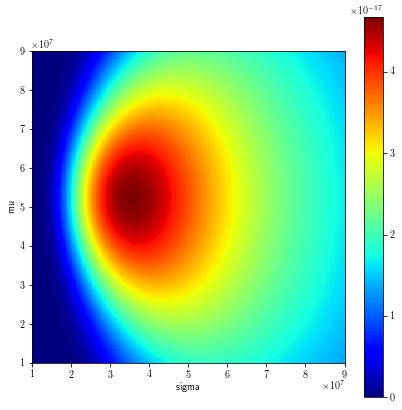

In [187]:
#for a given mu and sigma, whats the probability of getting those two values?
two_vals = df.loc[0].as_matrix()
size= 250
print two_vals

mu_start = 1e7
mu_end = 9e7
sig_start =1e7
sig_end=9e7

mus = np.linspace(mu_start,mu_end, size)
sigmas = np.linspace(sig_start,sig_end, size)

probs = np.zeros((size,size))


#calculate probabilities
for i in range (size):
    for j in range(size):
        probs[i][j] = -np.log(2*np.pi*sigmas[j]**2) -1./(2.*sigmas[j]**2) *squared_diff(two_vals, mus[i])
        probs[i][j] = np.exp(probs[i][j])
    
plt.figure(figsize=(7,7))
img = plt.imshow(probs, cmap = cm.jet, extent=[ sig_start,sig_end, mu_start, mu_end])
plt.ylabel("mu")
plt.xlabel("sigma")
plt.colorbar(img)

plt.show()

In [83]:
val = -np.log(2*np.pi*4e7**2) -1./(2.*4e7**2) *squared_diff(two_vals, 3.9e7)
print val, np.exp(val)

-37.6776486782 4.33316361697e-17


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


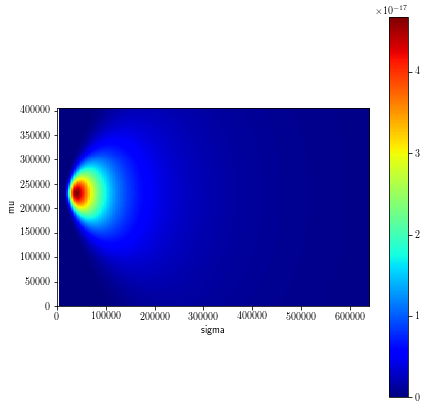

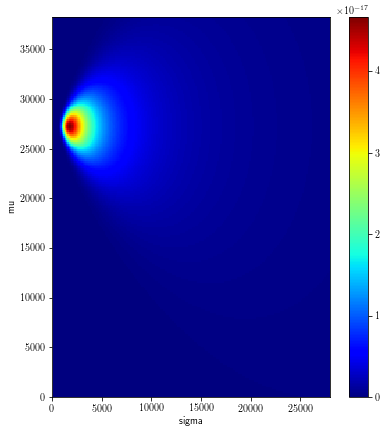

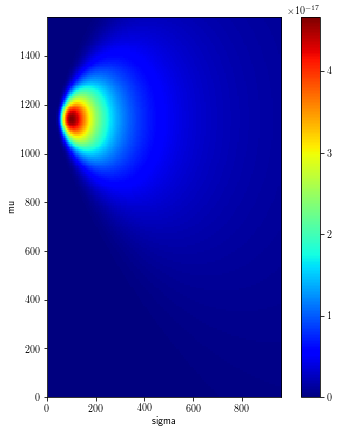

In [196]:
for i in range (1,10):
    
    two_vals = df.loc[i].as_matrix()
    if two_vals[0] == two_vals[1]:
        continue
    #print two_vals
    
    size= 200
    mu_start = two_vals[0] - two_vals[0] *2
    mu_end = two_vals[0] + two_vals[0] *2
    sig_start =two_vals[1] - two_vals[1] *2
    sig_end=two_vals[1] + two_vals[1] *2

    if mu_start< 0:
        mus = np.linspace(0,mu_end, size)
    else:
        mus = np.linspace(mu_start,mu_end, size)

    if sig_start<0:
            sigmas = np.linspace(0,sig_end, size)
    else:
        sigmas = np.linspace(sig_start,sig_end, size)

    
    
    probs = np.zeros((size,size))

    
    #calculate probabilities
    for i in range (size):
        for j in range(size):
            probs[i][j] = -np.log(2*np.pi*sigmas[j]**2) -1./(2.*sigmas[j]**2) *squared_diff(two_vals, mus[i])
            probs[i][j] = np.exp(probs[i][j])

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,1,1)
    plt.imshow(probs, cmap = cm.jet, extent=[ sigmas[0],sig_end, mus[0], mu_end])
    plt.ylabel("mu")
    plt.xlabel("sigma")
    plt.colorbar(img)

    plt.show()
    #negative sigma space does not make sense
    #negative mu also shouldn't make sense, since its representing time in this case
    

Try calculating the most likely mu and sigma for each row of two points

In [84]:
estimates = np.zeros_like(df)
df.tail()
def squared_diff(vals, val):
    return np.sum(( vals - val) **2)

#Probability for any given mu and sigma given data using MLE
for i in range( estimates.shape[0]):
    estimates[i,0] = df.loc[i].sum()/2.
    #val1 = (estimates[i,0] - df.iloc[i,0])**2
    #val2 = (estimates[i,0] - df.iloc[i,1])**2
    estimates[i,1] = ((squared_diff(df.loc[i].values,  estimates[i,0] ))/2.)**0.5
    if i%1000 ==999:
        print i


999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999
21999
22999
23999
24999


Get rid of the samples where the two times were the same, as not much can be inferred. Many are the same because there are both 1e9, which means they were stable. Some have stability times magnitudes smaller, but were still the same, so then the parameter perturbed did not affect its stability at all 

In [197]:
estimates = pd.DataFrame(estimates, columns=["Mu", "Sigma"])
print estimates.tail()
diff = estimates.loc[estimates["Sigma"]!=0.]
print diff.shape
diff_linear = diff.values.flatten().tolist()

                 Mu         Sigma
24995  3.885358e+04  20422.725798
24996  2.102411e+03    234.155436
24997  4.405240e+04  25343.813636
24998  3.057206e+04   1734.215453
24999  1.000000e+09      0.000000
(11498, 2)


Try using MCMC to find the most likely value of sigma and mu

In [140]:
# Define the probability function as likelihood * prior.

def lnprior(theta):
    mu, sig = theta
    if 0 < mu < 2e8 and 0 < sig < 2e8:
        return 0.0
    return -np.inf

def lnlike ( theta, x):
    mu,sig = theta
    return -0.5* len(x)*np.log(2*np.pi*sig**2) - 1./(2*sig**2) * squared_diff(x, mu)

def lnprob( theta, x):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x)


ndim, nwalkers = 2, 100
pos = [0.5 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[diff_linear])

#For burning in a few steps
pos, prob, state = sampler.run_mcmc(pos, 100)
sampler.reset()
sampler.run_mcmc(pos, 10000)

(array([[  3.93193439e+07,   1.30092197e+08],
        [  4.05876354e+07,   1.30447800e+08],
        [  4.00325029e+07,   1.30232664e+08],
        [  3.99666911e+07,   1.30045586e+08],
        [  4.09660735e+07,   1.31394604e+08],
        [  4.07314208e+07,   1.32063433e+08],
        [  3.95158081e+07,   1.29913932e+08],
        [  3.74415209e+07,   1.30326030e+08],
        [  3.93303478e+07,   1.32041298e+08],
        [  3.93037995e+07,   1.32028881e+08],
        [  3.82126094e+07,   1.32121259e+08],
        [  3.97988870e+07,   1.31199536e+08],
        [  3.98529255e+07,   1.30499472e+08],
        [  3.77828919e+07,   1.31208666e+08],
        [  4.12510412e+07,   1.30942063e+08],
        [  3.99920486e+07,   1.30621000e+08],
        [  3.83087107e+07,   1.30539093e+08],
        [  3.96707118e+07,   1.31153689e+08],
        [  4.01335163e+07,   1.30965448e+08],
        [  3.94597351e+07,   1.31784874e+08],
        [  3.95379943e+07,   1.32060464e+08],
        [  3.79165021e+07,   1.309

(1000000, 2)


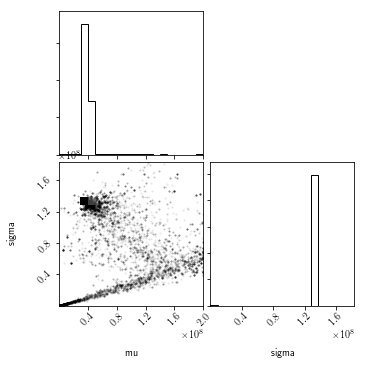

In [206]:
import corner
vals = sampler.chain.reshape((-1,2))
fig = plt.figure()
ax = fig.add_subplot("111")
#ax.scatter(vals[:,0], vals[:,1])
print vals.shape
#plt.show()
#print vals.shape
corner.corner(samples, labels= ["mu", "sigma"])

0.711922


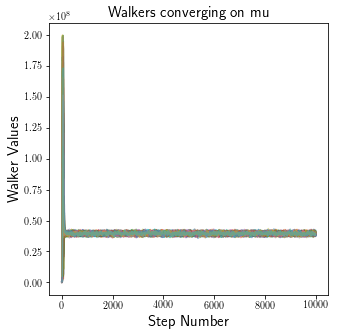

In [208]:
print np.mean(sampler.acceptance_fraction)
fig = plt.figure(figsize = (5,5))
#plt.rc('text', usetex=True)
ax = fig.add_subplot("111")
ax.plot(sampler.chain[:,:,0].T, alpha = 0.4)
ax.set_ylabel("Walker Values", fontsize = 15)
ax.set_xlabel("Step Number",fontsize = 15 )
ax.set_title("Walkers converging on mu", fontsize = 15)
#ax.set_ylim[(3.9e7, 4.1e7]
plt.show()

0.711922


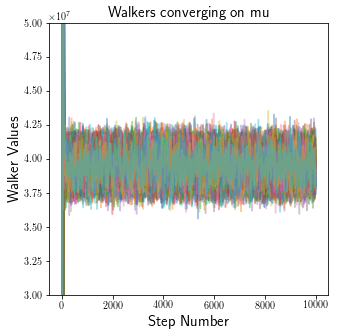

In [209]:
#Zoom in to see walkers finding the optimal value for the mean
print np.mean(sampler.acceptance_fraction)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot("111")
ax.plot(sampler.chain[:,:,0].T, alpha = 0.4)
ax.set_ylabel("Walker Values", fontsize = 15)
ax.set_xlabel("Step Number",fontsize = 15 )
ax.set_title("Walkers converging on mu", fontsize = 15)
#ax.set_ylim[(3.9e7, 4.1e7]
ax.set_ylim(3e7, 5e7)
plt.show()

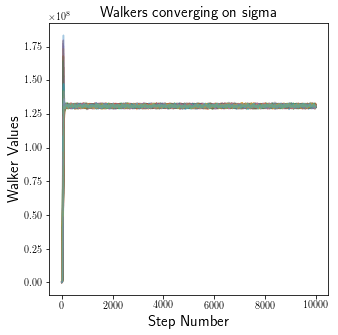

In [210]:
#Graph the walkers finding the optimal value for the sigma
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot("111")
ax.plot(sampler.chain[:,:,1].T, alpha = 0.4)
ax.set_ylabel("Walker Values", fontsize = 15)
ax.set_xlabel("Step Number",fontsize = 15 )
ax.set_title("Walkers converging on sigma", fontsize = 15)
plt.show()

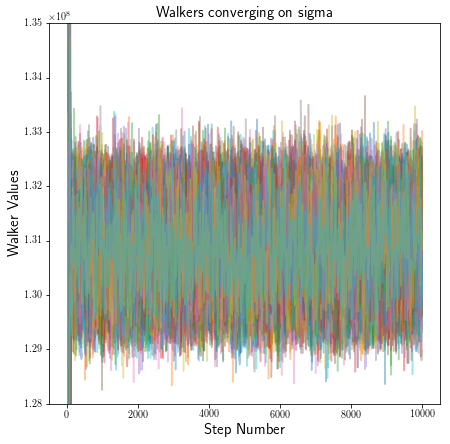

In [211]:
#Graph the walkers finding the optimal value for the sigma
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot("111")
ax.plot(sampler.chain[:,:,1].T, alpha = 0.4)
ax.set_ylabel("Walker Values", fontsize = 15)
ax.set_xlabel("Step Number",fontsize = 15 )
ax.set_title("Walkers converging on sigma", fontsize = 15)
#ax.set_ylim[(3.9e7, 4.1e7]
ax.set_ylim(1.28e8, 1.35e8)
plt.show()

Most number of samples in one bin 9135.0
Left bin edge 39489387.259
Right bin edge 39509380.4815
Most number of samples in one bin 12149.0
Left bin edge 130823987.446
Right bin edge 130842329.679


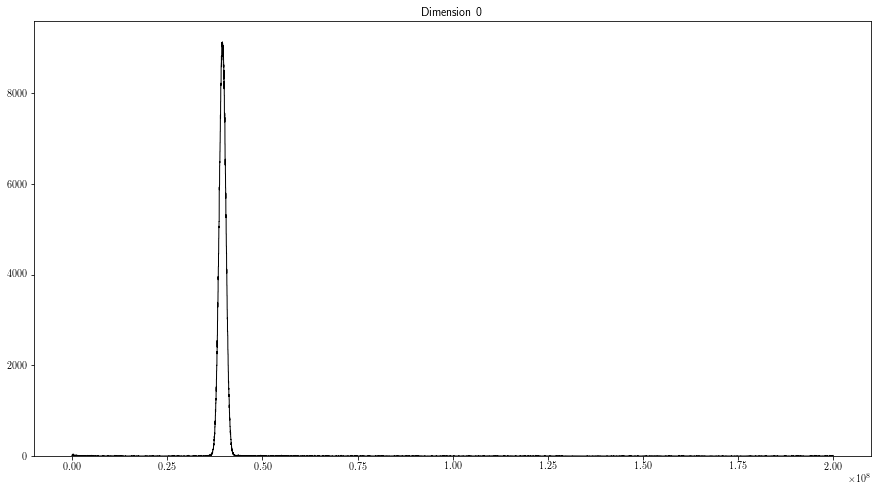

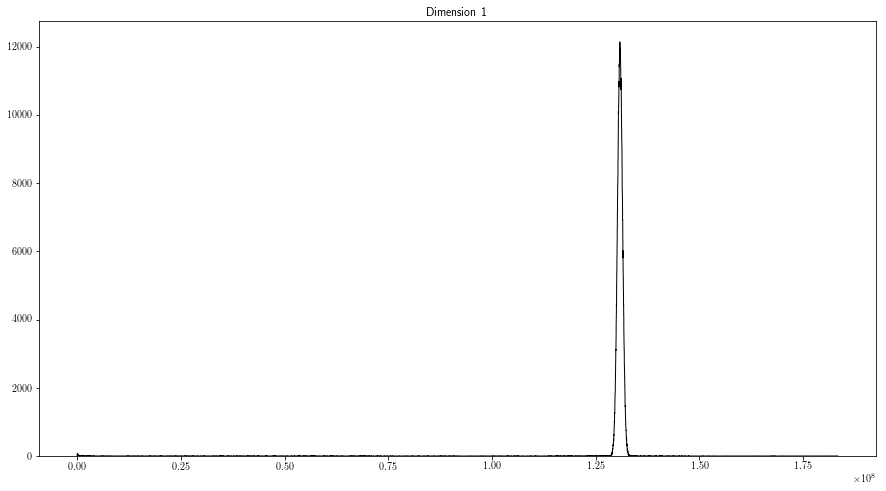

In [212]:
for i in range(ndim):
    #i =1
    plt.figure(figsize=(15,8))
    n, bins, patches = plt.hist(sampler.flatchain[:,i], 10000, color="k", histtype="step")
    index = np.where(n.max()==n)[0][0]
    print "Most number of samples in one bin", n.max()
    print "Left bin edge", bins[index]
    print "Right bin edge", bins[index +1]
    plt.title("Dimension {0:d}".format(i))
    #break

plt.show()

In [6]:
#Try plotting the integrand, with various values of sigma
def double_gauss(x, sigma, mu):
    #sigma = 10 #for now
    #x are the two x values from the delta times csv file
    vals = 1./(2*np.pi*sigma**2) * np.exp((-(x[0] - mu)**2 -(x[1] -mu)**2) / (2.*sigma**2) )
    return vals

In [60]:
log_times = np.log(plt_d_vals)
print log_times.shape
print log_times[:30,:]

(11244, 2)
[[ 16.32968811  18.23616649]
 [ 11.81210284  12.27048846]
 [  9.45436895   9.14008086]
 [  6.25601719   5.77160556]
 [  9.54300222   6.82451836]
 [ 12.79114512  13.37968632]
 [ 14.52134551  12.64848558]
 [ 17.12029131  14.10735675]
 [ 12.82350992  13.41797624]
 [  6.0070941    5.84109357]
 [  5.4643068    5.66080748]
 [ 10.42662927  10.64421445]
 [  7.03534277   7.05443009]
 [ 15.84118369  14.50130017]
 [ 10.1928292   10.86626396]
 [ 17.30244996  16.2083509 ]
 [ 12.58410356  12.05176564]
 [  5.25955266   5.82096734]
 [ 10.93068261   9.28575602]
 [ 10.31818889  10.19167611]
 [  6.00248789   6.52082273]
 [ 14.65229117  11.22075155]
 [ 19.25686354  18.68134151]
 [ 14.1694859   15.2012337 ]
 [  5.95437349   6.37302234]
 [ 13.21286572  13.49648415]
 [  8.58033104   5.8594505 ]
 [ 15.51355701  15.32431123]
 [ 10.95319307  10.85673395]
 [  9.36094539   8.96362353]]


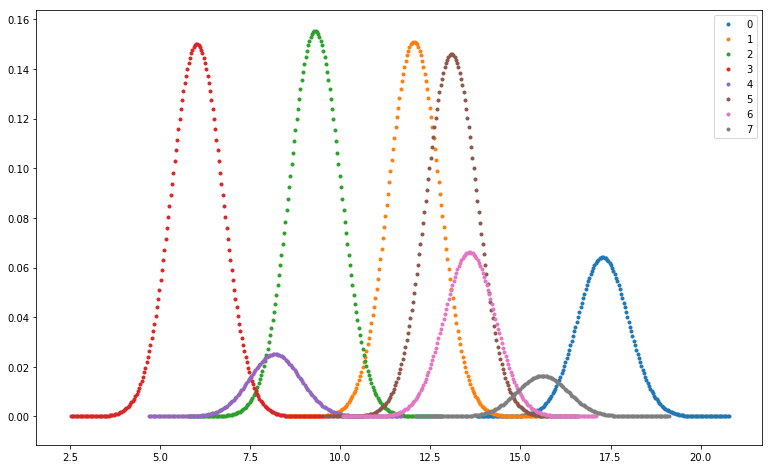

In [44]:
#Try ploting multiple guassians with log time
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot("111")
#vals = [10,20,30,40]
sigma = 1

for i, vals in enumerate(log_times[:8, :]):
    mid = np.sum(vals)/2.
    start = mid - (num_std*sigma)
        
    if(start > 0):
        mu = np.linspace(mid - (num_std*sigma) , mid + (num_std*sigma) , 200)
    else:
        mu = np.linspace(0 , mid + (num_std*sigma) , 200)
    
    values = double_gauss(vals, sigma, mu)
    ax.scatter(mu, values, label = i, marker = ".")
plt.legend()
plt.show()

[ 53.41639539  74.61667683] 64.0165361067
0.00917083399091
0.010650463622
0.0082995227625
0.00657409441386


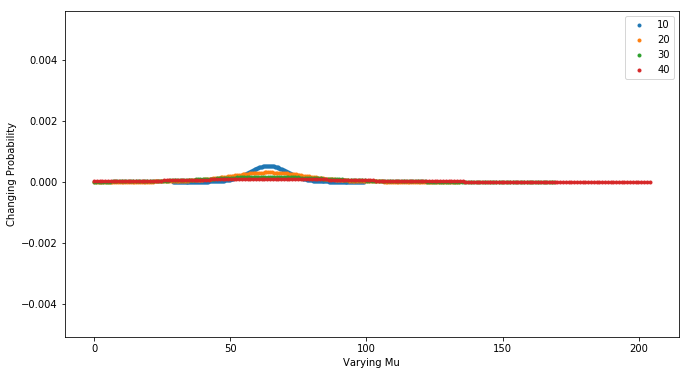

In [46]:
x = df.loc[24480].values
#x = df.loc[10640].values
#x = df.loc[24998].values
mid = np.sum(x)/2.

print x, mid
num_std = 3.5

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot("111")
#ax.set_ylim([-0.001, 0.001])

def area(x, sigma):
    #this computes gaussian integral with two points over mu from 0 to infinity
    area_analytic = -np.exp(-(x[0] - x[1])**2 / (4.*sigma**2.)) * (spec.erf(-1e5)) /(4. *np.pi**0.5 * sigma)
    area_analytic += np.exp(-(x[0] - x[1])**2 / (4.*sigma**2.)) * (spec.erf(x[0]+x[1])) /(4. *np.pi**0.5 * sigma)
    return area_analytic

vals = [10,20,30,40]
for val in vals:
    sigma = val
    start = mid - (num_std*sigma)
    
    
    if(start > 0):
        mu = np.linspace(mid - (num_std*sigma) , mid + (num_std*sigma) , 200)
    else:
        mu = np.linspace(0 , mid + (num_std*sigma) , 200)

    #since we want something between 0 and 1 for each gaussian, we dont need to take the log here
    #values = np.log(double_gauss(x,sigma,  mu))
    values = double_gauss(x, sigma, mu)
    ax.scatter(mu, values, label = val, marker = ".")
    #integrate from 3.5 stds on either side
    print area(x, sigma) #area_analytic
plt.legend()

#numerically integrate from 4std from the mean, defined as the average of the two stability time draws
ax.set_xlabel("Varying Mu")
ax.set_ylabel("Changing Probability")
plt.show()

In [30]:
spec.erf(-1)

-0.84270079294971478

In [47]:
#create a pdframe with different draws and that are not stable
indices = []
for i, vals in enumerate(df.as_matrix()):
    if vals[0] !=1e9 and vals[0] != vals[1]:
        indices.append(i)
        #print i
print len(indices)
plt_d=df.loc[indices]
print plt_d.shape

#try getting each of their contributions assuming sigma is 10.
sigma = 10
num_std = 3.5

sigma_range = np.linspace(100, 1e6, 1000)

areas = np.zeros(( sigma_range.shape[0], plt_d.shape[0])) # include area for each gaussian
plt_d_vals = plt_d.as_matrix()

11244
(11244, 2)


This was done with the log likelihood, now try taking log time, and then calculating the log likelihood from that

In [48]:
import time
sigma_range = np.linspace(0.5, 5, 75)

areas3 = np.zeros(( sigma_range.shape[0], log_times.shape[0])) # include area for each gaussia
start = time.time()

for j, sigma in enumerate(sigma_range):
    for i, val in enumerate(log_times):
        areas3[j][i] = -(val[0] - val[1])**2/(4. *sigma**2) +np.log(1+spec.erf(np.sum(val)/(2.*sigma))) - np.log(4*np.pi**0.5*sigma)
    
    print j
end = time.time()
print "Time", (end -start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Time 23.3497920036


In [49]:
# let sigma be 2
sigma = 2
count = 0
for i, val in enumerate(log_times):
    # -(val[0] - val[1])**2/(4. *sigma**2) +np.log(1+spec.erf(np.sum(val)/(2.*sigma))) - np.log(4*np.pi**0.5*sigma)
    amount =  -(val[0] - val[1])**2/(4. *sigma**2) +np.log(1+spec.erf(np.sum(val)/(2.*sigma))) - np.log(4*np.pi**0.5*sigma)
    print amount
    count+=amount
print count

-2.18582554104
-1.97179164009
-1.96483286707
-1.97333579281
-2.42054396163
-1.9803081009
-2.17788457271
-2.52602022222
-1.98074619162
-1.96039557653
-1.96111447725
-1.96161826111
-1.95868238988
-2.07086479399
-1.98700395258
-2.03347510143
-1.97637078272
-1.97840318299
-2.12777077168
-1.95965964669
-1.97545600452
-2.69462581443
-1.97936090432
-2.02519077419
-1.96962003343
-1.96368676739
-2.42135890167
-1.96089767697
-1.9592408266
-1.9685258452
-1.96271663162
-1.96378720356
-2.78105097234
-1.95914783216
-1.9919133955
-2.01469596914
-2.04813325993
-2.0791648956
-2.23861126252
-1.9690851863
-1.95883556037
-2.29243623385
-1.95881851105
-1.97463655694
-1.95883231394
-1.97827525789
-2.00655797536
-2.00111953495
-1.96001174458
-1.96868265557
-2.40182578932
-2.19392868064
-1.96194971294
-1.95980298594
-1.95870838192
-1.96598542372
-2.36887666969
-2.02357146873
-2.07023016279
-2.01180057479
-1.99733880028
-2.03040605437
-2.59826916778
-2.20412710561
-2.71414165126
-1.96994228504
-1.98357250325
-

-1.96001946391
-2.14377751318
-2.73250110644
-1.95872922025
-1.98093878483
-1.9661788594
-1.96096279984
-1.96254231187
-2.21964454505
-1.97883401786
-1.98228869982
-1.95867954507
-3.30771305833
-1.96406314245
-1.95879049397
-1.95867012604
-1.96226081287
-1.96478382007
-1.96102407159
-1.95896904573
-1.96309301906
-1.97555791911
-2.02485962272
-1.99392034639
-2.12593461313
-2.16616169988
-2.84953981899
-1.99136957136
-2.02864318448
-1.97261276082
-2.15068863062
-2.02885316276
-1.96120822254
-1.980892187
-1.96589189352
-2.47590736939
-1.98789257823
-1.98575641251
-2.02704928175
-1.98765248756
-1.95865978524
-1.98920404266
-2.50624463208
-1.98025080267
-2.05502334719
-2.07728300306
-2.89960422475
-2.00063293647
-2.21381198924
-2.36804070753
-1.95883581244
-1.95881233567
-2.06501340133
-2.30957926578
-2.05393126909
-2.56868544165
-1.97392899091
-2.3118203131
-1.98501148688
-2.0194487813
-2.02855659908
-1.95956722985
-1.96549282786
-2.03064357939
-1.9930381967
-1.96241288458
-1.98932854954
-

-1.95980011477
-1.95925785905
-1.97335110623
-4.19019301565
-1.96146843917
-2.02153717256
-1.96040037798
-2.00331010465
-1.95895920166
-3.93189106923
-1.95923320434
-1.96069379378
-1.97028385289
-1.99732783082
-2.03615576885
-2.24030781777
-1.97669472845
-2.00417705139
-1.9783483332
-1.9592083339
-1.96285712054
-2.07005721181
-1.96529401244
-1.95948602242
-2.00747161857
-2.03925361879
-2.04633651172
-1.96389245716
-2.08665236559
-2.33848391718
-2.08707205279
-1.96231721836
-2.30719100814
-2.04594605295
-2.29630765091
-1.97158382644
-2.06089027929
-1.99588200634
-2.03356054559
-2.02775252812
-1.95866261339
-1.95908191959
-1.98493535659
-2.22226465772
-1.96490315885
-1.96710507824
-1.97997952086
-1.99437845324
-2.03780427693
-2.26236075598
-1.9586744347
-2.34299989976
-1.98698847993
-1.96447485086
-1.95883806438
-1.95866327928
-2.53801616835
-1.99442336115
-1.98471136922
-2.27913443843
-2.24566126192
-2.08821649686
-2.20606727512
-2.10787460032
-2.04791967384
-4.06977489064
-1.9695874711

-1.95875032697
-2.04734107881
-1.96078300054
-1.98832228039
-2.0107862801
-2.23433672693
-3.31755839231
-1.99954301174
-2.02554957482
-1.97889335163
-1.97987676498
-1.95883817327
-2.1229286996
-5.24070991615
-1.95965530962
-1.96487009283
-2.3313799883
-1.96772896404
-2.06542758045
-2.26869803284
-2.42193825037
-2.1116867349
-2.07163782133
-2.08874179795
-1.9612831235
-2.62971016369
-2.00354575912
-1.96917552115
-2.19984727948
-2.11224387124
-1.96008487104
-1.99312016355
-1.97329452666
-2.27531397656
-2.04594107244
-2.04388707852
-2.00359152651
-1.95922933094
-2.11694962356
-2.21467543642
-2.01226273211
-2.01754034201
-1.97359173868
-2.2370974577
-1.97358193419
-1.99861055476
-1.96740163199
-2.01607197168
-1.96820798263
-2.12574189393
-3.31297899244
-2.12963721379
-2.59589552341
-1.98996907879
-1.98406488402
-2.18229350966
-1.96147339099
-2.00359014735
-2.16490040825
-1.95961494857
-1.96131029639
-1.99387051131
-1.95924158408
-1.98318456377
-1.97174789372
-1.96051967413
-2.13502483715
-

-1.95897734726
-1.96905093153
-2.05690909206
-1.97669783948
-2.01714072277
-2.46793647417
-2.08708255878
-1.97313106696
-1.98021868815
-2.15840635339
-1.95953699603
-2.02626532253
-1.95865952634
-2.25756521774
-2.08287579871
-2.20848454684
-1.95938758665
-1.99646321327
-1.96354625184
-2.17425047771
-1.95991343441
-1.95867071878
-1.96651112473
-2.09549676845
-1.95961718486
-1.9602848214
-1.9590263404
-1.97527815679
-1.95972508067
-1.97158407271
-1.96330331371
-1.95901960499
-2.02652958441
-2.12473775967
-2.15189147381
-2.04053819299
-2.40886564703
-2.45469114589
-1.97540250895
-1.97157313281
-2.43377452615
-2.17313043417
-2.04648583383
-1.97995847451
-1.96004888614
-2.00483825493
-1.98049315613
-2.07577280529
-1.97695932684
-2.07939565657
-1.95869770024
-2.01233924978
-2.60252809533
-1.97923733062
-2.19689680685
-1.95866629286
-1.96488331749
-2.12931608214
-1.97295549646
-2.00223334197
-2.82701416715
-1.96317974408
-2.05337706516
-2.00576418976
-2.02003359562
-2.19600129632
-2.080705867

-2.38032351987
-1.96121177223
-2.78421409593
-1.96814887094
-2.07220285224
-1.98183138561
-1.99026740307
-2.25437688578
-4.1752191587
-1.97908574108
-1.95865930405
-1.99787840435
-2.00617688712
-2.06946929799
-1.95868033123
-2.01386061477
-1.95871504129
-2.20933166975
-2.85569461619
-2.01566330728
-2.0820423871
-1.99983530771
-2.23908418516
-2.1955061315
-1.9609800824
-1.96369750683
-1.95916783011
-1.98069258309
-2.11071325837
-1.96046087798
-2.00968444293
-2.16683823155
-1.95924845953
-2.04896478166
-1.96760404443
-2.03338280909
-2.103248953
-2.08954319051
-2.92812160844
-2.06739058749
-1.98043326813
-2.32357383928
-1.97344587242
-1.96013633352
-1.96611760287
-2.11912056053
-1.95941812015
-2.31310401263
-2.21326156062
-1.96845169806
-2.01997424059
-1.961444036
-2.04434338703
-1.97529634057
-1.9803668885
-1.96967164884
-2.07243468197
-1.9902716095
-1.95874918525
-1.96117373127
-1.97366178161
-1.98680796412
-1.9615660096
-1.96608042764
-1.95986454765
-2.02300617905
-1.95916514901
-1.964

-2.09765436779
-2.15498182546
-1.96739156191
-2.0648685402
-2.02359392182
-1.96031516482
-1.95985993385
-2.75567476444
-2.06258563864
-1.96386879494
-1.98023901963
-2.16539683897
-2.00904824143
-1.96538347121
-2.43694973526
-2.78831992973
-2.08572041725
-1.96030937352
-2.06822912219
-2.07855465808
-1.95915461463
-1.96286515511
-2.36795094775
-1.96064517691
-1.95868350271
-1.96105483028
-2.7282598825
-2.05702415417
-2.02412975579
-1.95866017863
-1.96690115379
-1.95998906301
-2.03715008452
-1.95869962474
-1.95865930539
-1.9671516495
-2.17291706377
-1.98426989501
-1.95867764437
-2.57531932883
-2.00141093186
-1.96011179769
-1.96128268564
-2.28618183165
-1.97091093279
-2.17487508256
-1.98135842772
-1.95936589546
-2.01882674814
-2.11476241451
-1.98012420638
-1.96066396488
-2.8879553548
-1.9590573578
-2.06284357338
-1.98127694075
-2.01415121474
-1.97152838597
-2.17535808727
-1.95865931277
-2.09944112192
-4.12885468908
-1.96152788982
-1.95895340442
-1.98421894711
-1.98709885163
-1.95967324133


-2.84034341524
-2.00703341995
-1.9744779043
-2.17432172865
-1.96997573195
-1.99350172527
-1.98469486845
-1.98340437482
-2.95849088785
-1.99021645495
-2.17168369402
-2.14295226815
-1.96482898116
-1.98616333065
-2.47114641486
-1.95897831247
-2.47296665653
-1.95985973629
-2.02266064269
-1.95881334521
-2.07253341432
-1.96452023394
-2.01778980877
-1.96026009615
-2.55835937329
-2.13672721088
-1.96931576643
-2.69891870554
-1.95999183254
-1.95871338241
-2.03819728133
-1.97835229763
-2.1714801178
-1.98100214612
-2.49273246485
-1.95880574609
-1.95924587353
-2.08104815213
-1.95942090656
-2.03480607043
-2.00341265974
-2.99202409094
-1.9587657908
-2.02202541251
-4.16483813458
-2.30966326936
-2.05361561683
-1.99350476124
-1.96791224817
-2.69995980328
-1.99319749168
-1.97875456283
-2.50284298717
-1.96334927451
-1.97964450248
-1.98018346305
-2.69233610384
-2.08238968678
-1.99222114831
-2.040256353
-2.03189826717
-1.96027592552
-2.00601148348
-2.03928160442
-1.96715906959
-1.97717298029
-2.00221352147


-1.98522831036
-1.96707795905
-2.59622740755
-1.95948906532
-1.96333800591
-1.95870482222
-1.95884112085
-2.01624319784
-1.95920677662
-2.26815242704
-2.4718445753
-2.09982475332
-2.02814331017
-2.00780342458
-2.08332950946
-2.18340213313
-1.96000584626
-2.18838626062
-1.96176654868
-2.04907656561
-1.96160598223
-2.12067252486
-1.95866408991
-1.96782232018
-2.11606426856
-2.00378089302
-2.05069419274
-1.97036107356
-2.16208208765
-2.12594821176
-1.96273011908
-1.97031845768
-1.95879548213
-2.01248678576
-1.95913039595
-1.95874650822
-2.00188352447
-2.52580497914
-2.04127948849
-2.09721934012
-2.69683889307
-1.96083698674
-2.00583764667
-2.23330335265
-2.0805747818
-1.97434865481
-2.05630516512
-3.00923750214
-3.01668609384
-2.07618022533
-2.06855412994
-2.10661245514
-2.02464792593
-1.97176569069
-2.02044578467
-2.23685754205
-1.97561328231
-2.02097474959
-1.98666099656
-1.96594981782
-1.96400442019
-2.36607115413
-1.96041583724
-1.9730548159
-1.96130962854
-1.95877401843
-1.9752336890

-2.02746784827
-1.98339881895
-2.20451135461
-2.07513841098
-1.95893963459
-2.53912890177
-2.34047737289
-1.98062945799
-1.95867796363
-2.58927813606
-1.96172158558
-2.64786480719
-1.96928847228
-2.13213841607
-3.87144384096
-1.99333055366
-1.95906097403
-2.07558274455
-2.02142813769
-1.98802522653
-1.96077941391
-2.10484742649
-2.11708513451
-2.00547289173
-1.95971096865
-2.01335092477
-1.96521373707
-1.96626343007
-1.96620889895
-2.00844876979
-2.07701904736
-3.09164174418
-1.96385307014
-1.95878413494
-2.17989174102
-2.59276395302
-2.59255134172
-2.01250850396
-1.97845158744
-1.959616465
-1.95976334557
-2.11071923754
-2.51555089176
-1.95906068956
-2.00172015434
-1.96964397549
-1.97623293013
-2.0294419268
-1.95904525452
-2.01741807519
-2.01692777948
-1.9586637772
-1.9610428393
-1.97784628195
-2.06433164422
-2.48396461271
-1.9644222737
-2.27231781781
-2.15802480102
-1.95896971062
-2.00006739841
-2.00029047901
-2.14326529912
-2.41532719733
-2.1520699115
-2.23237129182
-2.06412991151
-2

-2.43603907911
-1.97130488569
-1.96238016623
-2.0331992491
-2.42175807317
-2.10773793007
-1.95899939911
-1.95868397145
-1.96139864756
-1.95872606535
-2.05377577235
-2.1593489566
-2.12794439054
-1.95938937665
-1.95866110957
-1.96234117996
-2.29340249954
-1.95966185228
-1.98978054322
-2.06329838989
-1.97310801986
-1.96113322075
-2.42360856329
-2.08958349657
-1.96268895322
-1.96056948283
-2.18196693421
-2.38018266922
-2.0874125543
-2.10243074064
-1.9838401276
-1.95923690298
-2.17372604805
-2.01400851275
-2.08256003078
-1.96442081357
-1.97054200048
-2.03056879875
-1.95869185406
-2.13543004897
-2.22104278144
-2.00853672199
-2.05585693172
-1.973679028
-2.41900625742
-1.95933673305
-1.95879017375
-1.96441218087
-2.36512337692
-1.96315370582
-1.95869869117
-2.10264368302
-1.95867047443
-2.10138673912
-1.98179262032
-2.12665853404
-1.96255463271
-1.98006674177
-1.95978560771
-2.04915831487
-1.99936648278
-2.20677084754
-2.2267213049
-1.98286154347
-2.06099484582
-1.98116511218
-1.95982980278
-1

-2.19667392256
-2.04559882625
-1.95901287213
-2.50281374542
-2.04732351071
-1.95865950295
-1.97000551316
-2.49245803552
-2.42320612266
-1.98387647269
-2.00140578391
-2.03259298132
-2.49794504124
-1.96079292914
-1.97174322348
-2.46161796527
-2.5771274561
-1.991565906
-2.13751752668
-1.97178394601
-2.44177728967
-2.19449655282
-2.15235407479
-2.69945262179
-1.95869120763
-1.95970361582
-1.95867176707
-2.02269098237
-1.97802551812
-1.99683871204
-1.98804446857
-1.96911355145
-1.99377181504
-1.97229329664
-1.95868285557
-2.05495282056
-1.95915678888
-1.96983140271
-2.0357617508
-1.99461514865
-1.9591658054
-1.9751125718
-1.97162446951
-7.27857170289
-2.16141460111
-2.25441939743
-1.96742463381
-1.95933954472
-1.95868319683
-2.62962690135
-1.96250620323
-2.21392733245
-2.30565617195
-2.24785973511
-1.95885342136
-2.20906811632
-2.05227807273
-2.62987634908
-2.06430075634
-3.79664776908
-2.00145969389
-2.01507713641
-2.12454329155
-2.01351473905
-1.96234559811
-1.96580591398
-2.30404718154
-

-1.95947233283
-1.96068252119
-1.97844017407
-2.33304645386
-1.96481471182
-2.22661912672
-1.99648872132
-1.98451307478
-1.99688260319
-1.97882052553
-3.32207926215
-2.45116993838
-1.95894217823
-2.13164679355
-1.97134834632
-3.65869767019
-2.01584878356
-2.08915879153
-1.9626071447
-2.04935159589
-2.00561253381
-1.99369469196
-1.97732179991
-1.98910882353
-1.95971786066
-1.98233922564
-1.96345189166
-2.00149637403
-1.99225086146
-1.98117769183
-1.9912753087
-1.96020457482
-1.95874067485
-6.999223094
-1.95881114334
-2.04953596282
-2.09865985113
-1.97365093327
-2.01010083541
-1.96679656733
-1.98084991453
-2.14482553074
-2.10285536357
-2.71614324251
-1.96424701932
-1.95916227798
-2.25200689976
-1.99144088888
-1.99619652602
-2.09290609181
-1.96049572952
-1.9587800853
-2.12294574008
-1.96415090765
-1.95866038434
-1.95872716116
-1.9633288467
-2.07127936535
-2.07193315474
-1.97221395402
-1.96834575994
-1.98586769726
-2.16484184202
-1.96041258608
-1.9622383564
-1.9598815227
-1.96248093177
-2.

-2.00322130998
-1.9637840377
-2.21568865258
-1.98697450791
-1.96671997791
-2.15729420082
-1.97955005112
-1.95925411651
-1.97353360722
-1.96257222434
-1.96160056487
-2.10963412804
-2.02373865282
-2.17069788468
-2.09490256749
-1.99332713316
-1.98624800663
-1.96427653927
-1.96990605516
-1.95885779753
-2.18955620168
-1.97859234859
-2.00623263801
-1.98008757563
-2.35066295802
-2.35007943574
-2.37484605051
-2.05493712467
-2.4659729204
-1.97426001614
-2.03056632622
-1.96882320882
-1.96063582187
-2.2559478335
-1.97434856784
-1.97289674221
-2.03095019731
-1.98058037479
-1.97090714564
-2.07034363391
-2.24678278045
-1.95976059722
-1.98452113461
-1.98231448619
-2.1156723704
-2.06327115578
-2.34810914487
-1.98184868308
-2.10089750537
-1.98211983539
-1.97251773044
-2.37807120207
-2.01952799727
-2.02289405002
-2.05431141672
-2.23164743386
-2.20146606884
-1.966302355
-1.99378552538
-1.99587515783
-1.97253658252
-2.10518595875
-2.04827631294
-1.96624578257
-2.85012098654
-2.16295756084
-3.77212131218
-

-2.05556296617
-1.96060594829
-1.9620571294
-1.9616212585
-1.96155248326
-1.96079014346
-2.94673205248
-2.2773752595
-2.24130499186
-1.97968413228
-2.21393154766
-1.9703135006
-2.17420768489
-2.08594056379
-1.97287575373
-1.95938026736
-1.95868796501
-2.35886479631
-1.96022862935
-2.5339497137
-2.04505385198
-1.96111246924
-1.95865931146
-1.95917700397
-1.96785298434
-1.98337247691
-2.17588704359
-1.9672124462
-1.97533591322
-1.96743579125
-2.00108529635
-1.96274345645
-2.16314658581
-1.97208212576
-1.96170283451
-1.96086781396
-1.99993309797
-2.14375814928
-1.97516793575
-2.04365904734
-2.08848292857
-2.11687400911
-1.97048106283
-1.95867514563
-2.14832694986
-1.95880567867
-2.11347906825
-1.958659965
-1.96676416242
-1.98904221115
-1.96816195056
-2.06848069003
-1.97379727983
-2.26083999467
-2.28362438121
-2.0953413246
-1.96218034415
-1.99809189233
-1.95866810395
-1.98411210652
-1.95877792256
-2.10994215351
-2.04244174883
-2.85364806403
-2.03960223397
-2.12814222122
-1.96510585439
-1.9

-1.95875169456
-1.95890732869
-3.82511015761
-1.95877293335
-2.01363616074
-1.97558071816
-2.20252193241
-2.06133392761
-2.01468521278
-1.96134615162
-1.95868310674
-1.99234061188
-1.98448288298
-2.17082946018
-1.97140434255
-1.96832413645
-1.962503747
-1.95881479966
-1.95918228757
-1.95881639122
-1.97690364186
-1.9602561835
-1.96053319854
-1.97783186298
-1.96066863139
-1.95958771659
-1.98536917672
-1.98304576359
-1.96651781165
-2.05905452745
-1.9780622288
-1.95960009537
-2.24719045129
-2.16849521104
-1.95870752844
-2.20534197093
-2.24484291764
-2.16903128494
-1.96056510102
-2.03094600052
-2.02680407524
-2.05871109551
-1.95873296808
-1.96068024479
-1.95912335134
-2.00468410928
-1.96000262224
-1.9661811844
-1.95965401045
-1.98725860218
-1.98112662165
-1.95877061414
-1.98066283806
-2.70487477922
-1.98483325549
-2.02749595931
-1.95866854061
-1.95919184291
-1.98670963383
-1.95866506415
-2.09655391083
-2.02961210801
-1.9630908699
-1.96416023558
-2.0454905539
-1.97174201881
-1.96505115615
-3

-2.18689044983
-1.96690519872
-3.89372022785
-1.97644001033
-2.08116217054
-1.95877391906
-1.98313899446
-1.95873389155
-1.95905942514
-1.97405314114
-2.15734603579
-1.97449271154
-2.05129611315
-1.97001984924
-1.963473849
-1.95914372827
-2.20245211268
-2.05649161332
-2.04759479077
-1.95993456705
-1.96111814655
-2.31132210771
-2.05608891866
-1.96708043651
-1.96181830582
-1.97612868889
-1.9726794837
-1.95972314473
-1.99533331985
-1.98647773025
-1.98832837209
-2.09135143423
-1.95869154133
-2.0820175474
-1.95883276265
-2.18100079131
-1.96300368217
-1.95865930753
-1.9988797116
-1.97336142971
-2.00280871156
-2.04395012251
-1.96178631046
-2.06605472959
-1.95946547977
-23624.1916306


In [59]:
#see how the areas change as sigma changes
summed_Areas2 = np.zeros(areas3.shape[0])
start = time.time()
for  i, val in enumerate(areas3):
    vals = np.sum(val)
    print vals, sigma_range[i], np.exp(vals)
    summed_Areas2[i] = vals
end = time.time()
print "Time", (end -start)
max_prob =  np.max(summed_Areas2)
ind = np.where(summed_Areas2 == max_prob)
print summed_Areas2[ind[0][0]]
print sigma_range[ind[0][0]]

-32050.6284987 0.5 0.0
-28087.2909119 0.560810810811 0.0
-25456.0020225 0.621621621622 0.0
-23683.5467001 0.682432432432 0.0
-22485.3205261 0.743243243243 0.0
-21682.425791 0.804054054054 0.0
-21158.2408806 0.864864864865 0.0
-20834.3896334 0.925675675676 0.0
-20656.8222238 0.986486486486 0.0
-20587.4332346 1.0472972973 0.0
-20598.8425063 1.10810810811 0.0
-20671.0494992 1.16891891892 0.0
-20789.2332654 1.22972972973 0.0
-20942.2727948 1.29054054054 0.0
-21121.7317149 1.35135135135 0.0
-21321.1490112 1.41216216216 0.0
-21535.5354786 1.47297297297 0.0
-21761.0109837 1.53378378378 0.0
-21994.5396883 1.59459459459 0.0
-22233.7344413 1.65540540541 0.0
-22476.7106754 1.71621621622 0.0
-22721.9761763 1.77702702703 0.0
-22968.3471441 1.83783783784 0.0
-23214.8837287 1.89864864865 0.0
-23460.8401273 1.95945945946 0.0
-23705.6256716 2.02027027027 0.0
-23948.7742751 2.08108108108 0.0
-24189.9202926 2.14189189189 0.0
-24428.7793307 2.2027027027 0.0
-24665.1329104 2.26351351351 0.0
-24898.816145 2

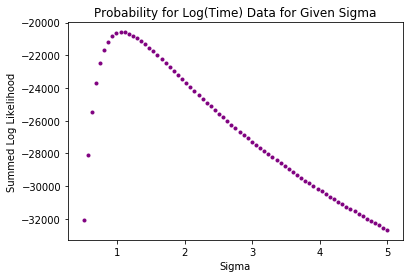

In [53]:
plt.scatter(sigma_range, summed_Areas2, color = "purple", marker =".")
plt.title("Probability for Log(Time) Data for Given Sigma")
plt.ylabel("Summed Log Likelihood")
plt.xlabel("Sigma")
plt.show()


1.3838965267367376e-87